# CNN with reduced features from dataset and generated features

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../datasets/combined_reduced.csv')

In [3]:
X1 = np.load('../datasets/final_X.npy')

In [4]:
# Convert the DataFrame to a NumPy array
df_array = df.to_numpy()

# Stack the DataFrame and the NumPy array horizontally
X_final = np.hstack((df_array, X1))

In [5]:
target = pd.read_csv('../datasets/kag_red.csv')

In [6]:
from sklearn.model_selection import train_test_split

y = target['subreddit']  # Target

In [7]:
# merge X_final and y to single dataframe
df_final = pd.DataFrame(X_final)
df_final['subreddit'] = y

In [8]:

X_final_d = df_final.drop('subreddit', axis=1)
y_final_d = df_final['subreddit']


In [9]:
# convert X_final_d and y_final_d to numpy arrays
X_final_d = X_final_d.to_numpy()

In [10]:
# print the shape of X_final and y
print(X_final_d.shape)
print(y_final_d.shape)

(374499, 1140)
(374499,)


In [11]:
# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final_d, y_final_d, test_size=0.2, random_state=42)


In [12]:

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping 

# Step 1: Encode the categorical target variable (y_train) using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))
# Step 2: Flatten the encoded labels
y_train_encoded = y_train_encoded.argmax(axis=1)
y_val_encoded = y_val_encoded.argmax(axis=1)
y_test_encoded = y_test_encoded.argmax(axis=1)
y_train_encoded = to_categorical(y_train_encoded) 
y_val_encoded = to_categorical(y_val_encoded) 
y_test_encoded_cat = to_categorical(y_test_encoded)


## Compiling and training the model

In [14]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'CNN_combined.ipynb'

In [15]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import accuracy_score
import numpy as np

wandb.init(project='Best_Models', name='CNN')

params = {
    'filters': 16, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 200, 'act': 'tanh'
}

wandb: Currently logged in as: aayushach16 (boys69). Use `wandb login --relogin` to force relogin


In [16]:
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 3 or epoch == 6:  
            self.model.save("model_tanh_{}.hd5".format(epoch))

In [17]:
import tensorflow as tf

model = Sequential()
model.add(Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation=params['act'],
                 input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=params['pool_size']))
model.add(Flatten())
model.add(Dense(params['dense_units'], activation=params['act']))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

saver = CustomSaver()

history = model.fit(X_train_reshaped, y_train_encoded, epochs=10, batch_size=16,
                    validation_data=(X_val_reshaped, y_val_encoded),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                               WandbCallback(), saver])

X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test_encoded, y_pred_classes)

accr = model.evaluate(X_test_reshaped, y_test_encoded_cat)

wandb.log({'test_loss': accr[0], 'test_acc': accr[1]})
wandb.log({'validation_loss': history.history['val_loss'][len(history.history['val_loss']) - 1], 'epoch': len(history.history['val_loss'])})





wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
14041/14044 [============================>.] - ETA: 0s - loss: 0.9969 - accuracy: 0.6494

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best)... Done. 0.1s


14044/14044 [==============================] - 105s 7ms/step - loss: 0.9969 - accuracy: 0.6494 - val_loss: 0.8680 - val_accuracy: 0.6910
Epoch 2/10
14042/14044 [============================>.] - ETA: 0s - loss: 0.8398 - accuracy: 0.6991

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best)... Done. 0.1s


14044/14044 [==============================] - 141s 10ms/step - loss: 0.8398 - accuracy: 0.6991 - val_loss: 0.8381 - val_accuracy: 0.7008
Epoch 3/10
14038/14044 [============================>.] - ETA: 0s - loss: 0.8147 - accuracy: 0.7067

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best)... Done. 0.1s


14044/14044 [==============================] - 133s 9ms/step - loss: 0.8149 - accuracy: 0.7067 - val_loss: 0.8262 - val_accuracy: 0.7029
Epoch 4/10
14042/14044 [============================>.] - ETA: 0s - loss: 0.7981 - accuracy: 0.7107

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: model_tanh_3.hd5/assets


INFO:tensorflow:Assets written to: model_tanh_3.hd5/assets


14044/14044 [==============================] - 144s 10ms/step - loss: 0.7981 - accuracy: 0.7108 - val_loss: 0.8222 - val_accuracy: 0.7011
Epoch 5/10
14041/14044 [============================>.] - ETA: 0s - loss: 0.7843 - accuracy: 0.7147

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best)... Done. 0.1s


14044/14044 [==============================] - 159s 11ms/step - loss: 0.7844 - accuracy: 0.7146 - val_loss: 0.8079 - val_accuracy: 0.7086
Epoch 6/10
14039/14044 [============================>.] - ETA: 0s - loss: 0.7728 - accuracy: 0.7180

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best)... Done. 0.1s


14044/14044 [==============================] - 140s 10ms/step - loss: 0.7729 - accuracy: 0.7180 - val_loss: 0.8030 - val_accuracy: 0.7081
Epoch 7/10
14044/14044 [==============================] - ETA: 0s - loss: 0.7633 - accuracy: 0.7211

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: model_tanh_6.hd5/assets


INFO:tensorflow:Assets written to: model_tanh_6.hd5/assets


14044/14044 [==============================] - 139s 10ms/step - loss: 0.7633 - accuracy: 0.7211 - val_loss: 0.7978 - val_accuracy: 0.7098
Epoch 8/10
14043/14044 [============================>.] - ETA: 0s - loss: 0.7538 - accuracy: 0.7240

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best)... Done. 0.1s


14044/14044 [==============================] - 136s 10ms/step - loss: 0.7539 - accuracy: 0.7240 - val_loss: 0.7921 - val_accuracy: 0.7126
Epoch 9/10
14044/14044 [==============================] - 94s 7ms/step - loss: 0.7456 - accuracy: 0.7264 - val_loss: 0.7925 - val_accuracy: 0.7115
Epoch 10/10
14041/14044 [============================>.] - ETA: 0s - loss: 0.7371 - accuracy: 0.7289

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_164232-fpsixxaw/files/model-best)... Done. 0.1s


2341/2341 [==============================] - 5s 2ms/step - loss: 0.7812 - accuracy: 0.7164


In [14]:


# Save X_test_reshaped and y_test_encoded_cat to numpy arrays   
np.save('X_test_CNN_combined', X_test_reshaped)
np.save('y_test_encoded_CNN_combined', y_test_encoded)

## Results

In [18]:

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_classes))

Accuracy: 0.7163951935914553
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1577
           1       0.88      0.85      0.86      9182
           2       0.78      0.76      0.77      1254
           3       0.79      0.80      0.80     11419
           4       0.85      0.73      0.78      1754
           5       0.77      0.62      0.69      4899
           6       0.65      0.73      0.68     23472
           7       0.69      0.54      0.61      4724
           8       0.79      0.64      0.71      1766
           9       0.69      0.66      0.67      1788
          10       0.64      0.64      0.64     13065

    accuracy                           0.72     74900
   macro avg       0.75      0.70      0.72     74900
weighted avg       0.72      0.72      0.72     74900



In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute confusion matrix in percentage of total test samples
cm = confusion_matrix(y_test_encoded, y_pred_classes)


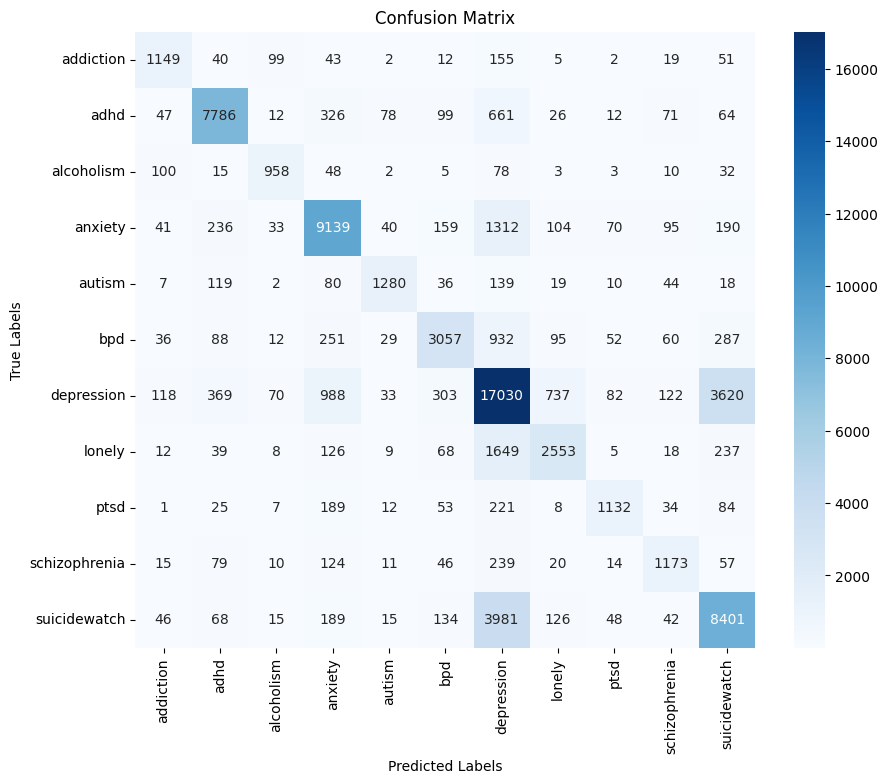

In [20]:


# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [21]:
# print count of categories in y_test
print(y_test.value_counts())

subreddit
depression       23472
suicidewatch     13065
anxiety          11419
adhd              9182
bpd               4899
lonely            4724
schizophrenia     1788
ptsd              1766
autism            1754
addiction         1577
alcoholism        1254
Name: count, dtype: int64


In [22]:
wandb.finish()

accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▄▃▃▂▂▂▁▁▁
test_acc,▁
test_loss,▁
val_accuracy,▁▄▄▄▆▆▆▇▇█
val_loss,█▅▄▄▃▂▂▁▁▁
validation_loss,▁
accuracy,0.72888
best_epoch,9
best_val_loss,0.78821


In [23]:
del model